## MCMC example

In [1]:
import pymc3 as pm
import theano.tensor as tt
import theano as theano
import arviz as az
# --------------------
# extras for analysis
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from scipy import stats
import seaborn as sns
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # 
from matplotlib import cm
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings("ignore")

/Users/pradyumna/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/pradyumna/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
def z_score1(data_all,z_score_var, part_def = 0):
    z_matrix=[]
    z_matrix_aux=[]
    
    if part_def==0:
        z_matrix = (data_all[z_score_var] - data_all[z_score_var].mean())/ data_all[z_score_var].std()
    else:
        for i in (data_all[part_def].unique()):
            Choicedata = data_all.loc[data_all[part_def] == i]    
        
            pX_A= pd.to_numeric(Choicedata[z_score_var]) 
            pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)
    
            z_matrix_aux= pX_zA.values
        
            for  j in range(len(z_matrix_aux)):    
                z_matrix.append(z_matrix_aux[j])
    return z_matrix

---------------------
--------------------

 ## Load dataset 

In [3]:
data_all = pd.read_csv('data/DataFoodFramingNotebook_31.csv') 
# restart number of participants to make it sequencial (for )
data_all['Part'] = data_all['Part'].replace(data_all.Part.unique(), list(range(len(data_all.Part.unique()))))
# choose only like trials
data_part_all =  data_all.loc[data_all.BlockCond == 1] 

### Extract relevant variables

In [4]:
data_part_all.columns

Index(['Unnamed: 0', 'Part', 'TrialN', 'PairID', 'LItem', 'LValue', 'RItem',
       'RValue', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond',
       'tDDT', 'lIA_DT', 'rIA_DT', 'tGSF', 'lastFixat', 'DV', 'zDV', 'absDV',
       'zAbsDV', 'zConf', 'zChoiceRT', 'DFam', 'LFam', 'RFam', 'TotFam',
       'TotVal', 'FamCh', 'FamUnCh', 'ValCh', 'ValUnCh', 'Correct',
       'LValConfBDM', 'LFamConfBDM', 'RValConfBDM', 'RFamConfBDM', 'zDFam',
       'zTotFam', 'zTotVal', 'zValCh', 'zValUnCh', 'zFamCh', 'zFamUnCh',
       'zGSF', 'zDDT', 'absDDT', 'zAbsDFam', 'zLValue', 'zRValue', 'zLFam',
       'zRFam', 'zLValConfBDM', 'zLFamConfBDM', 'zRValConfBDM', 'zRFamConfBDM',
       'ConfSplit', 'GSFMedSplit', 'DDTMedSplit'],
      dtype='object')

In [5]:
# z-score values
data_part_all['zLValue'] = z_score1(data_part_all,'LValue', 'Part')
data_part_all['zRValue'] = z_score1(data_part_all,'RValue', 'Part')

data_part_all['zAbsDVal'] = z_score1(data_part_all,'absDV', 'Part')
data_part_all['zConf'] = z_score1(data_part_all,'Conf', 'Part')
data_part_all['zRT'] = z_score1(data_part_all,'ChoiceRT', 'Part')
data_part_all['zTotVal'] = z_score1(data_part_all,'TotVal', 'Part')


In [6]:
# load input 
val_a = data_part_all.zLValue.values
val_b = data_part_all.zRValue.values
absDVal = data_part_all.zAbsDVal.values
totVal = data_part_all.zTotVal.values

chosenByPart = data_part_all.ChosenITM.values
rtByPart = data_part_all.zRT.values
confByPart = data_part_all.zConf.values

# 1. defining a GLM

In [7]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * rtByPart, sigma=sigma, observed=confByPart)

    # Inference!
    trace = pm.sample(3000, cores=2)  # draw 3000 posterior samples using NUTS sampling
    burned_trace = trace[1000::2] 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 4 seconds.


# analyze trace

<Figure size 504x504 with 0 Axes>

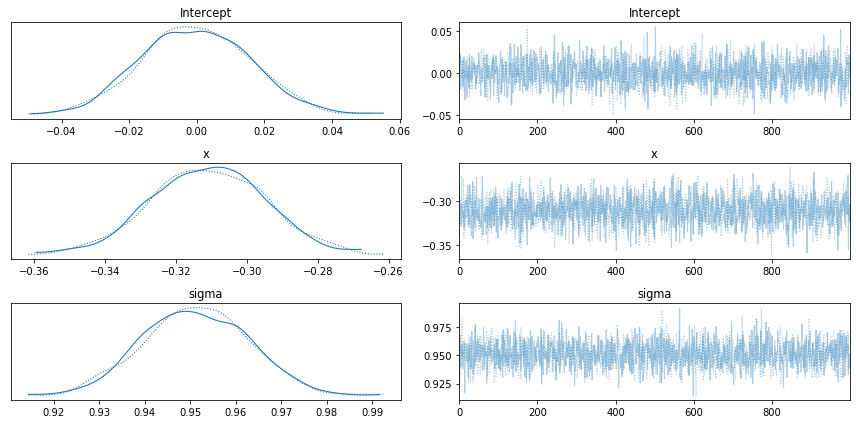

In [8]:
plt.figure(figsize=(7, 7))
pm.traceplot(burned_trace)
plt.tight_layout();

In [9]:
rhats_params = az.rhat(burned_trace, method="folded")
rhats_params

<xarray.Dataset>
Dimensions:    ()
Data variables:
    Intercept  float64 1.004
    x          float64 0.9995
    sigma      float64 0.9996

## check convergence: rhat<1.05 indicates good convergence

In [10]:
az.summary(burned_trace, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.000,0.016,-0.030,0.028,0.0,0.0,1975.976,1298.411,1984.645,1950.658,1.004
x,-0.311,0.016,-0.341,-0.281,0.0,0.0,1958.783,1958.783,1939.993,1863.182,1.000
sigma,0.951,0.011,0.930,0.972,0.0,0.0,1963.282,1962.716,1957.653,1669.160,1.000


In [11]:
pm.waic(burned_trace)
waic1 = pm.waic(burned_trace)

In [12]:
pm.loo(burned_trace)

Computed from 2000 by 3720 log-likelihood matrix

         Estimate       SE
elpd_loo -5093.46    58.99
p_loo        4.79        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [13]:
ppc = pm.sample_posterior_predictive(burned_trace, samples=2000, model=model,var_names = ['x','y','Intercept','sigma'])              #var_names = ['choice]) 

In [14]:
ppc

{'x': array([-0.28833805, -0.30096786, -0.30424347, ..., -0.31039892,
        -0.32226047, -0.30443548]),
 'y': array([[ 0.19927405, -0.6876274 , -0.0974256 , ..., -1.26608951,
          0.41891988,  0.60682182],
        [ 0.27321859, -0.25198631,  0.74084306, ...,  0.10947143,
         -1.50889047,  0.24774992],
        [-1.3476741 ,  2.02531966, -1.55013567, ...,  0.53441885,
         -0.6019879 , -0.48632273],
        ...,
        [ 0.37147419,  1.00196153, -0.77154124, ...,  0.59971043,
          0.85862817, -1.05447197],
        [-0.28676763, -1.40512098,  1.87662141, ..., -0.6258934 ,
          0.28947316, -1.65308532],
        [ 0.10076427, -1.20152165, -0.4812872 , ..., -0.11404029,
          1.61874547, -0.88527434]]),
 'Intercept': array([-0.00066858,  0.01080998,  0.02143173, ...,  0.0130881 ,
         0.00980962,  0.0071518 ]),
 'sigma': array([0.92835516, 0.92559238, 0.9371775 , ..., 0.95690418, 0.94466368,
        0.93993557])}

# show relationship

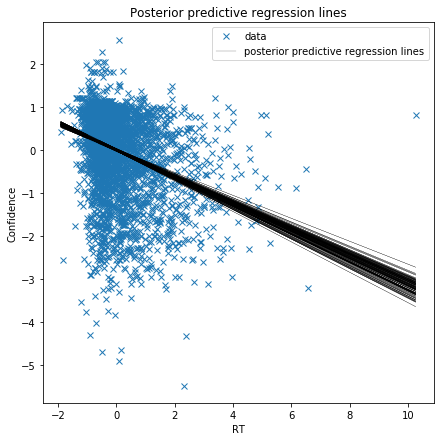

In [15]:
plt.figure(figsize=(7, 7))
plt.plot(rtByPart, confByPart, "x", label="data")
pm.plot_posterior_predictive_glm(trace, samples=100,eval=rtByPart, label="posterior predictive regression lines")
#plt.plot(rtByPart, true_regression_line, label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("RT")
plt.ylabel("Confidence");

## 2. Using "simple" GLM definition

In [16]:
df1 = pd.DataFrame()
df1['rt'] =rtByPart
df1['conf'] = confByPart

In [17]:
with pm.Model() as model2:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula("conf ~ rt", df1)
    step = pm.Metropolis()
    trace2 = pm.sample(3000, step =step)  # draw 3000 posterior samples using NUTS sampling
    burned_trace2 = trace2[1000::2] 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [rt]
>Metropolis: [Intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [18]:
az.summary(burned_trace2, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.001,0.015,-0.028,0.028,0.001,0.0,832.134,618.873,831.242,728.270,1.006
rt,-0.311,0.014,-0.340,-0.287,0.000,0.0,944.723,944.723,945.644,750.446,1.008
sd,0.951,0.011,0.930,0.972,0.000,0.0,743.165,742.639,734.934,753.191,1.003


In [45]:
pm.waic(burned_trace2)


Computed from 4000 by 3720 log-likelihood matrix

          Estimate       SE
elpd_waic -5093.08    58.99
p_waic        4.31        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [19]:
waic2 = pm.waic(burned_trace2)

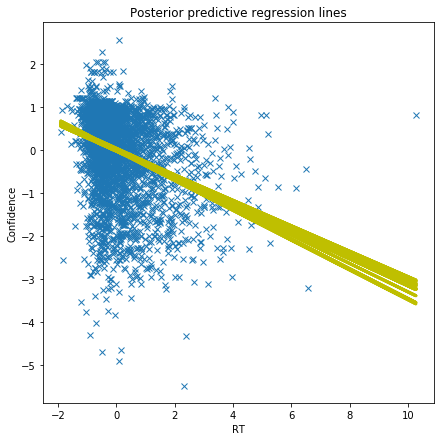

In [20]:
ppc = pm.sample_posterior_predictive(burned_trace2, samples=50, model=model2,var_names = ['Intercept','rt','Intercept','sd'])              #var_names = ['choice]) 

plt.figure(figsize=(7, 7))
plt.plot(rtByPart, confByPart, "x", label="data")
#pm.plot_posterior_predictive_glm(trace2, samples=100, label="posterior predictive regression lines")
for i in range(len(ppc['rt'])):
    plt.plot(rtByPart, ppc['rt'][i]*rtByPart + ppc['Intercept'][i] , label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
#plt.legend(loc=0)
plt.xlabel("RT")
plt.ylabel("Confidence");

# 3. defining a hierarchical GLM

In [21]:
part_names = data_part_all.Part.unique()
part_idx = data_part_all.Part.values
part_idx = part_idx.astype(int)
n_part = len(data_part_all.Part.unique())

In [22]:
part_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [23]:
part_idx

array([ 0,  0,  0, ..., 30, 30, 30])

In [24]:
part_idx

array([ 0,  0,  0, ..., 30, 30, 30])

In [25]:
n_part

31

In [26]:
len(rtByPart)

3720

In [27]:
len(part_idx)

3720

In [28]:
len(confByPart)

3720

In [29]:
part_idx

array([ 0,  0,  0, ..., 30, 30, 30])

In [30]:
with pm.Model() as model_hier:  # model specifications in PyMC3 are wrapped in a with-statement
    
    # Define priors fix
    mu_intercept = pm.Normal("mu_intercept", mu = 0, sigma=100)
    sigma_intercept = pm.HalfNormal("sigma_intercept", 5.0) 
    
    mu_x_coeff = pm.Normal("mu_x",mu =  0, sigma=100)
    sigma_x_coeff = pm.HalfNormal("sigma_x", 5.0) 
    
    # Define priors mix
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0) # noise param
    
    intercept = pm.Normal("Intercept", mu = mu_intercept, sigma=sigma_intercept, shape = n_part)
    x_coeff =   pm.Normal("x", mu = mu_x_coeff, sigma=sigma_x_coeff, shape = n_part)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept[part_idx] + x_coeff[part_idx] * rtByPart, sigma=sigma, observed=confByPart)

    # Inference!
    trace_hier = pm.sample(3000, cores=2)  # draw 3000 posterior samples using NUTS sampling
    burned_trace_hier = trace_hier[1000::2] 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma, sigma_x, mu_x, sigma_intercept, mu_intercept]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 26 seconds.
There were 1184 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46796230760066176, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1202 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5289800801470287, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


# analyze trace

<Figure size 504x504 with 0 Axes>

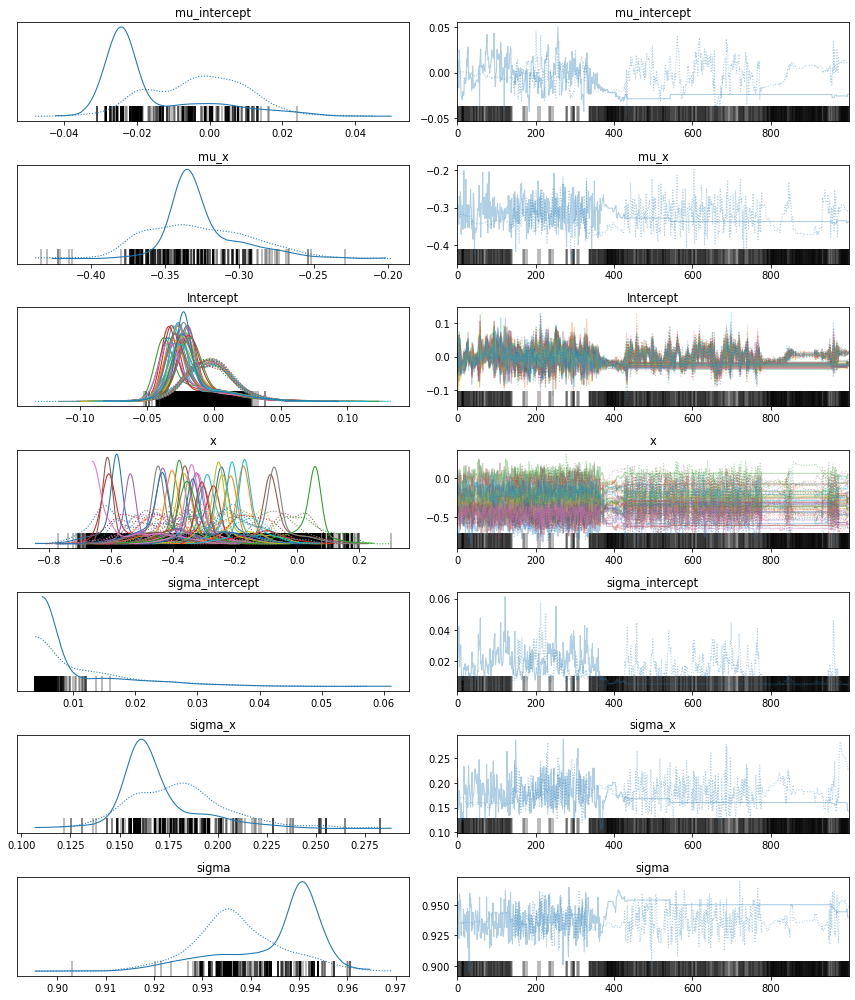

In [31]:
plt.figure(figsize=(7, 7))
pm.traceplot(burned_trace_hier)
plt.tight_layout();

In [32]:
rhats_params = az.rhat(burned_trace_hier, method="folded")
rhats_params

<xarray.Dataset>
Dimensions:          (Intercept_dim_0: 31, x_dim_0: 31)
Coordinates:
  * Intercept_dim_0  (Intercept_dim_0) int64 0 1 2 3 4 5 6 ... 25 26 27 28 29 30
  * x_dim_0          (x_dim_0) int64 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
Data variables:
    mu_intercept     float64 1.017
    mu_x             float64 1.344
    Intercept        (Intercept_dim_0) float64 1.025 1.019 1.078 ... 1.024 1.07
    x                (x_dim_0) float64 1.286 1.028 1.323 ... 1.462 1.537 1.061
    sigma_intercept  float64 1.111
    sigma_x          float64 1.114
    sigma            float64 1.017

## check convergence: rhat<1.05 indicates good convergence

In [33]:
az.summary(burned_trace_hier, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_intercept,-0.0093,0.0157,-0.0288,0.0186,0.0066,0.0050,5.5664,5.5664,6.3254,30.3566,1.2426
mu_x,-0.3256,0.0315,-0.3743,-0.2601,0.0047,0.0033,45.5792,45.5792,50.5858,138.2952,1.3440
Intercept[0],-0.0099,0.0201,-0.0363,0.0350,0.0065,0.0048,9.4382,9.4382,8.4590,288.5358,1.1657
Intercept[1],-0.0079,0.0204,-0.0384,0.0359,0.0062,0.0045,10.7261,10.7261,8.4588,256.5398,1.1695
Intercept[2],-0.0094,0.0199,-0.0385,0.0357,0.0051,0.0037,15.2571,15.2571,13.9677,233.8788,1.1046
Intercept[3],-0.0114,0.0219,-0.0373,0.0342,0.0091,0.0068,5.7521,5.7521,5.4241,3.1644,1.2836
Intercept[4],-0.0099,0.0213,-0.0379,0.0331,0.0076,0.0056,7.8214,7.8214,8.0035,258.2923,1.1909
Intercept[5],-0.0083,0.0197,-0.0396,0.0330,0.0051,0.0036,15.1230,15.1230,14.6854,213.0998,1.1229
Intercept[6],-0.0107,0.0200,-0.0359,0.0315,0.0069,0.0051,8.4241,8.4241,9.0829,356.3257,1.1569
Intercept[7],-0.0090,0.0192,-0.0328,0.0356,0.0060,0.0043,10.3562,10.3562,11.9312,254.5701,1.1162


In [34]:
pm.waic(burned_trace_hier)
waic_hier = pm.waic(burned_trace_hier)

In [35]:
pm.loo(burned_trace_hier)

Computed from 2000 by 3720 log-likelihood matrix

         Estimate       SE
elpd_loo -5050.56    59.88
p_loo       34.44        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [36]:
ppc = pm.sample_posterior_predictive(trace, samples=2000, model=model,var_names = ['x','y','Intercept','sigma'])              #var_names = ['choice]) 

# show relationship

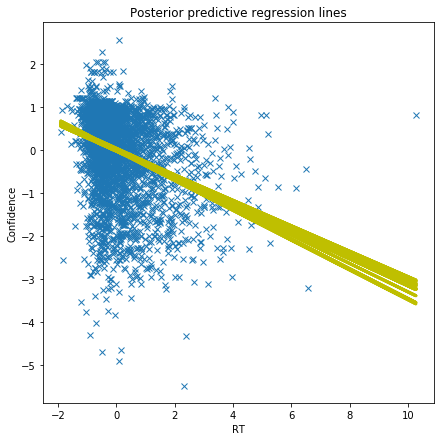

In [37]:
ppc = pm.sample_posterior_predictive(burned_trace2, samples=50, model=model2,var_names = ['Intercept','rt','Intercept','sd'])              #var_names = ['choice]) 

plt.figure(figsize=(7, 7))
plt.plot(rtByPart, confByPart, "x", label="data")
#pm.plot_posterior_predictive_glm(trace2, samples=100, label="posterior predictive regression lines")
for i in range(len(ppc['rt'])):
    plt.plot(rtByPart, ppc['rt'][i]*rtByPart + ppc['Intercept'][i] , label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
#plt.legend(loc=0)
plt.xlabel("RT")
plt.ylabel("Confidence");

# Model comparison

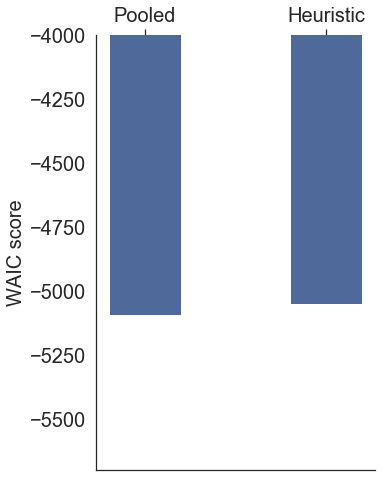

In [50]:
ysize = 20
ticksize = 20
nticks = 7

fig, ax = plt.subplots(1,1,figsize=(5,8))
sns.set(style='white', font_scale=1.8)

ax.set_facecolor('xkcd:white')
width_bars = 0.4
bars1 = plt.bar([0,1],[ waic1[0], waic_hier[0]], color='#4F6A9A',width = width_bars, hatch = '')

#patterns = ('', '')
plt.ylim(-5700,-4000)
plt.ylabel('WAIC score',fontsize = ysize )
    
# Turn off tick labels
plt.xticks([0,1],['Pooled','Heuristic'],fontsize = 20)
plt.axhline(0, color='black', lw=2, alpha=0.5)
plt.yticks(fontsize=ticksize)
ax.yaxis.set_major_locator(plt.MaxNLocator(nticks))
ax.xaxis.tick_top()

sns.despine()

plt.show()


 ------------------------------

# Additional model: fit to choice

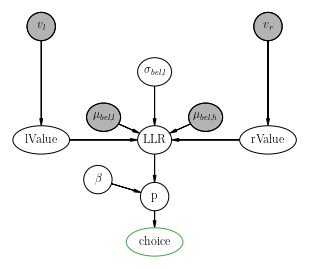

In [7]:
import daft
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

# generate nodes for the graphical representation

pgm = daft.PGM()

s_color = {"ec": "#46a546"}

pgm.add_node("lValue", r"lValue", -0.5, 3, aspect=2)
pgm.add_node("rValue", r"rValue", 3.5, 3, aspect=2)
pgm.add_node("sigmaGen1", r"$\sigma_{bel,l}$", 1.5, 4.2, aspect=1.2)
#pgm.add_node("sigmaGen2", r"$\sigma_{bel,h}$", 1.8, 4.2, aspect=1.2)
pgm.add_node("mu1", r"$\mu_{bel,l}$", 0.6, 3.4, aspect=1.2,observed = True)
pgm.add_node("mu2", r"$\mu_{bel,h}$", 2.4, 3.4, aspect=1.2,observed = True)
pgm.add_node("vl", r"$v_l$", -0.5, 5, aspect=1,observed = True)
pgm.add_node("vr", r"$v_r$", 3.5, 5, aspect=1,observed = True)
pgm.add_node("LLR", r"LLR", 1.5, 3, aspect=1.2)
pgm.add_node("b", r"$\beta$", 0.5, 2.3, aspect=1)
pgm.add_node("p", r"p", 1.5, 2, aspect=1)
pgm.add_node("choice", r"choice", 1.5, 1.2, aspect=2,plot_params=s_color)


# add edges to the graphical model 
pgm.add_edge("vl", "lValue", xoffset=-0.1)
pgm.add_edge("vr", "rValue", xoffset=-0.1)
pgm.add_edge("mu1", "LLR", xoffset=-0.1)
pgm.add_edge("mu2", "LLR", xoffset=-0.1)
pgm.add_edge("sigmaGen1", "LLR", xoffset=-0.1)
#pgm.add_edge("sigmaGen2", "LLR", xoffset=-0.1)
pgm.add_edge("rValue", "LLR", xoffset=-0.1)
pgm.add_edge("lValue", "LLR", xoffset=-0.1)
pgm.add_edge("LLR", "p", xoffset=-0.1)
pgm.add_edge("b", "p", xoffset=-0.1)
pgm.add_edge("p", "choice", xoffset=-0.1)



pgm.render()
#pgm.savefig("XX.pdf")
#pgm.savefig("PEB_BasicModel_2GenVariance_choice_new.png", dpi=200)


## Extract relevant constant for this model

mean values -> high: 0.8115919288920124 ,  low:-0.8110766237123309
stdev values -> high: 0.6723780146253707 ,  low:0.48162916118718574


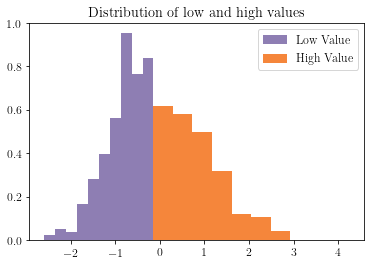

In [8]:
value_sort = val_a.copy()
value_sort.sort()
value_low = value_sort[:int(len(value_sort)/2)]
value_high = value_sort[int(len(value_sort)/2) + 1 :]

plt.title(r"Distribution of low and high values")
figsize(7, 7)
plt.hist(value_low, bins=10, alpha=0.85,
             label=r"Low Value", color="#7A68A6", normed=True)
plt.hist(value_high, bins=10, alpha=0.85,
             label=r"High Value", color="#F47118", normed=True)
plt.legend()

print ('mean values -> high: '+ str(value_high.mean()) +' ,  low:'+ str(value_low.mean()))
print ('stdev values -> high: '+ str(value_high.std()) +' ,  low:'+ str(value_low.std()))

n_trials = len(val_a)
mu = [value_low.mean(), value_high.mean()]

In [9]:
val_a

array([-0.89873549,  1.13613732, -0.89873549, ..., -1.5980889 ,
        0.86050941, -0.67611453])

In [10]:
value_sort

array([-2.59446284, -2.59446284, -2.54253641, ...,  3.51678506,
        4.2381639 ,  4.2381639 ])

In [24]:
with pm.Model() as model_choice1:
    # get value for each trial, generate sample for each 
    sigmaBel = pm.Uniform('sigmaBel', lower=0.5, upper=5) # low value distribution
    sigmaSamp = pm.Uniform('sigmaSamp', lower=0.5, upper=5)

    lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
    rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
    
    # estimate odds ratio for the choice of right option
    
    LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.)))) - 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) + 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) -
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.))))  )

    beta = pm.Normal("beta", mu=0, sigma=0.001, testval = 0)
   # alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR)))    
    
    choice = pm.Bernoulli("choice", p, observed=chosenByPart)

    start = pm.find_MAP()
    step = pm.Metropolis()
    nchains = 4
    trace_choice1 = pm.sample(3000, step =step ,chains= nchains)
    burned_trace_choice1 = trace_choice1[1000::2]    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [rVal]
>Metropolis: [lVal]
>Metropolis: [sigmaSamp]
>Metropolis: [sigmaBel]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [28]:
with pm.Model() as model_choice1:
# get value for each trial, generate sample for each 
    sigmaGen1 = pm.Uniform('sigmaBel1', lower=0.5, upper=5) # low value distribution
    #sigmaGen2 = pm.Uniform('sigmaBel2', lower=0.5, upper=5) # high value distribution
    sigmaSamp = pm.Uniform('sigmaSamp', lower=0.5, upper=5)
    
    lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
    rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
    
    # estimate odds ratio for the choice of right option
    
    LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaGen1, 2.)))) - 
                                   tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaGen1, 2.)))) + 
                                   tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaGen1, 2.)))) -
                                   tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaGen1, 2.))))  )

    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR) ))    
    
    choice = pm.Bernoulli("choice", p, observed=chosenByPart)

    conf = pm.Deterministic('conf',abs(LLR))   

    
    
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    nchains = 4
    trace_choice1 = pm.sample(3000, step =step ,chains= nchains)
    burned_trace_choice1 = trace_choice1[1000::2]    



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [rVal]
>Metropolis: [lVal]
>Metropolis: [sigmaSamp]
>Metropolis: [sigmaBel1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [30]:
az.summary(burned_trace_choice1, round_to=4,var_names=["beta",'sigmaBel1','sigmaSamp'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,-4.9003,3.1648,-10.9768,-1.1329,1.4240,1.0732,4.9396,4.9396,4.8878,16.1275,2.4943
sigmaBel1,2.9057,0.9307,1.5234,4.5440,0.4283,0.3239,4.7205,4.7205,4.8986,15.9943,2.4828
sigmaSamp,0.5001,0.0001,0.5000,0.5003,0.0000,0.0000,1703.1937,1703.1937,1286.1807,1176.5809,1.0065


In [ ]:
pm.traceplot(burned_trace_choice1, var_names=["beta",'sigmaBel','sigmaSamp'] )

Slope Coef [[0.8257689]]
Slope coef [[0.83648292]]
Slope Coef [[0.83648292]]


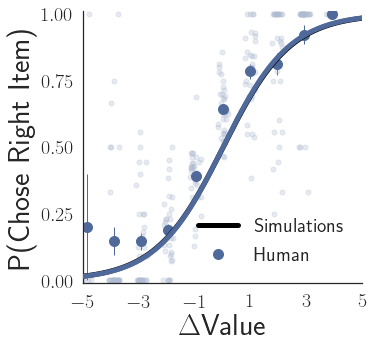

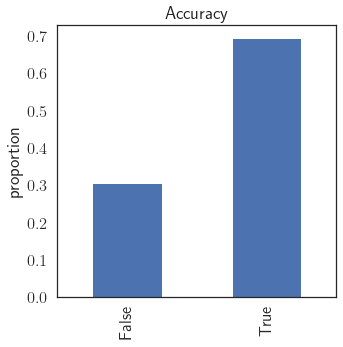

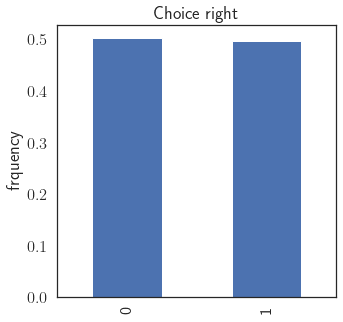

In [31]:
simHumanBehavPlots (burned_trace_choice1, model_choice1,data_part_all,colorP = ['#4F6A9A','#AFBBD1'])

In [15]:
def simHumanBehavPlots (burned_trace, model_peb1,data_part_all_test,colorP = ['#4F6A9A','#AFBBD1']):

    ppc = pm.sample_posterior_predictive(burned_trace, samples=50, model=model_peb1,var_names = ['choice']) # generates samples from the posterior, im this case the samples consider the 120 trials inputs

    posterior_df = pd.DataFrame()
    posterior_df['choice'] = ppc['choice'].flatten()
    posterior_df['lValue'] = np.tile(val_a, len(ppc['choice']))
    posterior_df['rValue'] = np.tile(val_b, len(ppc['choice']))
    posterior_df['dValue'] = np.tile(val_b - val_a, len(ppc['choice']))
    posterior_df['sumValue'] = np.tile(val_b + val_a, len(ppc['choice']))
    posterior_df['absDValue'] = np.tile(np.abs(val_b - val_a), len(ppc['choice']))
    RbiggerL = np.tile((val_b>val_a), len(ppc['choice']))
    posterior_df['correct'] = RbiggerL == posterior_df['choice']
    
    data_part = pd.DataFrame()    
    data_part['choice'] = data_part_all_test.ChosenITM
    data_part['dValue'] = data_part_all_test.zRValue - data_part_all_test.zLValue 
    # z-score participant
    data_part['zAbsDValue'] =  data_part_all_test.zAbsDV.values
    data_part['zSumValue'] = data_part_all_test.zTotVal.values
    # add chosen and unchosen
    data_part['Part'] = data_part_all_test.Part
    
    ## FIGURE
    logisticplot_simpl ('Simulations', posterior_df, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                      modlowcol='#000000', title='empty',xlim = [-5,5])
    
    logisticplot_simplDots ('Human', data_part, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                            meanCol=colorP[0], subjCol = colorP[1], title='empty',xlim = [-5,5])
    
    logisticplot_simpl ('', data_part, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                      modlowcol=colorP[0], title='empty', linewidth = 3 ,xlim = [-5,5])
    
    plt.show()
    
        # FIGURE
    posterior_df['correct'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Accuracy')
    plt.ylabel('proportion')
    plt.show()
    
    posterior_df['choice'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Choice right')
    plt.ylabel('frquency')
    plt.show()


In [16]:
def logisticplot_simpl (modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                  modlowcol='#AAAAAA', title='empty', xlim = [-5,5],linewidth = 5):
    
    sns.set(font_scale=1.5, style='white')
    figsize(5,5)
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    logit_low = {}

    # I think this defines the problem space
    X_test = np.linspace(-10,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data[xaxis][:, np.newaxis],
            data [yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Slope Coef',clf.coef_)
    
    #Plotting the predictive lines
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(xlim[0], xlim[1])

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(frameon=False, prop={'size':20})
    
    sns.despine()

In [17]:
def logisticplot_simplDots (modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                  meanCol='#AAAAAA',subjCol='#000000', title='empty', xlim = [-5,5]):
    
    sns.set(font_scale=1.5, style='white')
    figsize(5,5)
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    logit_low = {}

    # I think this defines the problem space
    X_test = np.linspace(-10,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data[xaxis][:, np.newaxis],
            data [yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Slope coef',clf.coef_)
    
    #      data.groupby(['Part', 'difficulty']).choice.mean()

    
    # generate scatter to plot pariticipants means
    
    levels =  (np.max(data[xaxis]) - np.min(data[xaxis]))/10
    lev_label = np.arange(np.min(data[xaxis]), np.max(data[xaxis]) + levels,levels) 
    
    difficulty2= []
    for i in range(len(data[xaxis].values)):
         difficulty2.append( lev_label[ int((data[xaxis].values[i] - np.min(data[xaxis]) )//levels)] )
            
    data['difficulty'] = np.around(difficulty2, decimals = 3)        
    
    subject_means = data.groupby(['Part', 'difficulty']).choice.mean()
    means = subject_means.groupby('difficulty').mean()
    sems = subject_means.groupby('difficulty').sem()
    
    #Plotting the predictive lines
    #line_low = sub.scatter(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 

    # plot subject means
    scatter_data = subject_means.reset_index()
    x_scatter = scatter_data['difficulty'] 
    jittr = np.random.uniform(low=-max(x_scatter)/10,high=max(x_scatter)/10,size=len(scatter_data))/2
    sub.plot(x_scatter+jittr, scatter_data.choice.values, marker='o', ms=5, markerfacecolor=subjCol, color=subjCol,alpha=0.3,linestyle="None")

    # plot mean values
    sub.plot(list(means.index), means.values, 'o', markerfacecolor=meanCol, markersize = 10, fillstyle = 'full',
                    color=meanCol, linewidth=1,label=modlow)
    sub.vlines(list(means.index), means - sems, means + sems,
                      linewidth=1, color= meanCol)
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    #sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(xlim[0], xlim[1])

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(frameon=False, prop={'size':20})
    
    sns.despine()

In [18]:
def z_score1(data_all,z_score_var, part_def = 0):
    z_matrix=[]
    z_matrix_aux=[]
    
    if part_def==0:
        z_matrix = (data_all[z_score_var] - data_all[z_score_var].mean())/ data_all[z_score_var].std()
    else:
        for i in (data_all[part_def].unique()):
            Choicedata = data_all.loc[data_all[part_def] == i]    
        
            pX_A= pd.to_numeric(Choicedata[z_score_var]) 
            pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)
    
            z_matrix_aux= pX_zA.values
        
            for  j in range(len(z_matrix_aux)):    
                z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [ ]:
with pm.Model() as model_peb0:
    # get value for each trial, generate sample for each 
    sigmaGen1 = pm.Uniform('sigmaBel1', lower=0.5, upper=5) # low value distribution
    sigmaGen2 = pm.Uniform('sigmaBel2', lower=0.5, upper=5) # high value distribution
    sigmaSamp = pm.Uniform('sigmaSamp', lower=0.5, upper=5)
    
    lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
    rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
    
    # estimate odds ratio for the choice of right option
    
    LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaGen2 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaGen2, 2.)))) - 
                                   tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaGen1, 2.)))) + 
                                   tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaGen1, 2.)))) -
                                   tt.log(1/(sigmaGen2 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaGen2, 2.))))  )

    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
   # alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR) ))    
    
    #choice = pm.Bernoulli("choice", p, shape = n_trials)   
    choice = pm.Bernoulli("choice", p, observed=chosenByPart)

    conf = pm.Deterministic('conf',abs(LLR))   
   # betaConf = pm.Normal("betaConf", mu=0, tau=0.001, testval=0)
   # conf = pm.Deterministic("conf",1.0/(1. + tt.exp(betaConf*LLR)) )    
   # confRep = pm.Normal('confReport',mu = conf, sigma=0.025, observed=confNormByPart)  

nsample = 8000
nchains = 4
toburnsample = 800

with model_peb0:
    
    # to define multiple steps
    # step1 = pm.Metropolis([rv1, rv2])
    # step2 = pm.CategoricalGibbsMetropolis([rv3])
    # trace = pm.sample(..., step=[step1, step2]...)
    start = pm.find_MAP()
    step = pm.Metropolis()
    # remove the starting point in MAP to be able to run and avoid bad energy.
    if nchains>1:
        trace = pm.sample(nsample, step =step ,chains= nchains)
    else:
        trace = pm.sample(nsample, step =step )

    burned_trace0 = trace[toburnsample::2] 

In [ ]:
az.summary(burned_trace_hier, round_to=4)

In [27]:
# generate all values to be sorted to generate high and low value distributions
value_sort = data_part_all.copy()
value_sort = value_sort.zLValue.values

confByPart = data_part_all.zConf.values
choiceConfByPart = data_part_all.zChoiceConf.values

confNormByPart = norm_01(data_part_all,'zConf','Part')

NameError: name 'data_part_all' is not defined

In [ ]:
delta_og = data_part_all.zLValue
delta_og.hist()
plt.title(r"Distribution of values from participant")
print('mean of the value distribution: ' + str(val_a.mean()))
print('std of the value distribution: ' + str(val_a.std()))

In [ ]:
conf_og = data_part_all.zConf
conf_og.hist()
plt.title(r"Distribution of confidence from participant (zScored)")
print('mean of the confidence distribution: ' + str(conf_og.mean()))
print('std of the confidence distribution: ' + str(conf_og.std()))

In [ ]:
choiceConf_og = data_part_all0['Conf'] 
plt.hist(choiceConf_og)
plt.title(r"Distribution of zscored confidence from participant")
print('mean : ' + str(np.mean(choiceConf_og)))
print('std  : ' + str(np.std(choiceConf_og)))

In [ ]:
choiceConf_og = confNormByPart
plt.hist(choiceConf_og)
plt.title(r"Distribution of normalized 0-1 confidence from participant")
print('mean : ' + str(np.mean(choiceConf_og)))
print('std  : ' + str(np.std(choiceConf_og)))

## split values half

In [ ]:
value_sort.sort()
value_low = value_sort[:int(len(value_sort)/2)]
value_high = value_sort[int(len(value_sort)/2) + 1 :]

plt.title(r"Distribution of low and high values")
figsize(7, 7)
plt.hist(value_low, bins=10, alpha=0.85,
             label=r"Low Value", color="#7A68A6", normed=True)
plt.hist(value_high, bins=10, alpha=0.85,
             label=r"High Value", color="#F47118", normed=True)
plt.legend()

print ('mean values -> high: '+ str(value_high.mean()) +' ,  low:'+ str(value_low.mean()))
print ('stdev values -> high: '+ str(value_high.std()) +' ,  low:'+ str(value_low.std()))

In [ ]:
# extract parameters for the distribution corresponding to high and low values.
lvalParam = [value_low.mean(), value_low.std()]
hvalParam = [value_high.mean(), value_high.std()]
print ('low values distribution: mean:' +str(lvalParam[0]) + ', var:' +str(lvalParam[1]) )
print ('high values distribution: mean:' +str(hvalParam[0]) + ', var:' +str(hvalParam[1]) )

# Fit the model 
### 1st fit -  extract priors for sigmaSamp and beta

In [ ]:
n_trials = len (val_a)
# params for the generative model: mean and std
mu = [lvalParam[0],hvalParam[0]]
for i in range(1):
    
   # highSigmaSample = highSigmaSampSims[i]
   # lowSigmaSample = lowSigmaSampSims[i]
    
    print ('running sim repetition '+ str(i) )
    
    with pm.Model() as model_peb0:
        # get value for each trial, generate sample for each 
        sigmaGen1 = pm.Uniform('sigmaBel1', lower=0.5, upper=5) # low value distribution
        sigmaGen2 = pm.Uniform('sigmaBel2', lower=0.5, upper=5) # high value distribution
        sigmaSamp = pm.Uniform('sigmaSamp', lower=0.5, upper=5)
        
        lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
        rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
        
        # estimate odds ratio for the choice of right option
        
        LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaGen2 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaGen2, 2.)))) - 
                                       tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaGen1, 2.)))) + 
                                       tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaGen1, 2.)))) -
                                       tt.log(1/(sigmaGen2 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaGen2, 2.))))  )

        beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
       # alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
        p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR) ))    
        
        #choice = pm.Bernoulli("choice", p, shape = n_trials)   
        choice = pm.Bernoulli("choice", p, observed=chosenByPart)

        conf = pm.Deterministic('conf',abs(LLR))   
       # betaConf = pm.Normal("betaConf", mu=0, tau=0.001, testval=0)
       # conf = pm.Deterministic("conf",1.0/(1. + tt.exp(betaConf*LLR)) )    
       # confRep = pm.Normal('confReport',mu = conf, sigma=0.025, observed=confNormByPart)  
    
    nsample = 8000
    nchains = 4
    toburnsample = 800
    
    with model_peb0:
        
        # to define multiple steps
        # step1 = pm.Metropolis([rv1, rv2])
        # step2 = pm.CategoricalGibbsMetropolis([rv3])
        # trace = pm.sample(..., step=[step1, step2]...)
        start = pm.find_MAP()
        step = pm.Metropolis()
        # remove the starting point in MAP to be able to run and avoid bad energy.
        if nchains>1:
            trace = pm.sample(nsample, step =step ,chains= nchains)
        else:
            trace = pm.sample(nsample, step =step )
    
        burned_trace0 = trace[toburnsample::2] 

In [ ]:
az.plot_trace(burned_trace0, var_names=["sigmaSamp","beta"]);

In [ ]:
#ppc = pm.sample_posterior_predictive(burned_trace0, samples=50, model=model_peb0,var_names = ['choice','conf','gamma','sigmaSamp','sigmaGen1','sigmaGen2','beta','betaConf','conf','confReport']) # generates samples from the posterior, im this case the 
ppc = pm.sample_posterior_predictive(burned_trace0, samples=2000, model=model_peb0,var_names = ['choice','conf','sigmaSamp','sigmaBel1','sigmaBel2','beta','conf']) # generates samples from the posterior, im this case the 

## extract parameters
### -- Beta

In [ ]:
plt.hist(ppc['beta'].flatten())

beta_pos_mean = np.mean(ppc['beta'].flatten())
beta_pos_std = np.std(ppc['beta'].flatten())

print (beta_pos_mean,beta_pos_std)

### -- SigmaSampl

In [ ]:
plt.hist(ppc['sigmaSamp'].flatten())

sigmaSamp_pos_mean = np.mean(ppc['sigmaSamp'].flatten())
sigmaSamp_pos_std = np.std(ppc['sigmaSamp'].flatten())

print (sigmaSamp_pos_mean,sigmaSamp_pos_std)

In [ ]:
plt.hist(ppc['conf'].flatten())

In [ ]:
plt.hist(ppc['sigmaBel1'].flatten())

In [ ]:
plt.hist(ppc['sigmaBel2'].flatten())

In [ ]:
plt.bar([1,2],[np.mean(ppc['sigmaBel1'].flatten()),np.mean(ppc['sigmaBel2'].flatten())])
plt.xticks([1,2],["$\sigma_{Bel,1}$","$\sigma_{Bel,2}$"],fontsize=20)
plt.ylabel('Param', fontsize=20)
sns.despine()

### Model comparison

In [ ]:
print(pm.waic(burned_trace0))

### Plot simulations

In [ ]:
simHumanBehavPlots (burned_trace0, model_peb0,data_part_all_test)

In [ ]:
 ## Show 2D evidence vs confidence plot
ppc = pm.sample_posterior_predictive(burned_trace0, samples=50, model=model_peb0,var_names = ['choice','conf','sigmaSamp','sigmaBel1','sigmaBel2','beta','conf','LLR','lVal','rVal']) # generates samples from the posterior, im this case the 

bin_num = 6

df1 = pd.DataFrame()
df1['LVal_bin'] =pd.to_numeric(pd.qcut(val_a, bin_num , labels=range(bin_num)))
df1['RVal_bin'] = pd.to_numeric(pd.qcut(val_b, bin_num , labels=range(bin_num)))
df1['LLR'] = ppc['LLR'][0]

rowIDs = df1['LVal_bin']
colIDs = df1['RVal_bin']

# Create DV data
mat_2dim = np.zeros((rowIDs.max()+1,colIDs.max()+1))
mat_count = np.zeros((rowIDs.max()+1,colIDs.max()+1)) 
for i in range(len(df1)):
        x = int(df1.iloc[i].LVal_bin)
        y = int(df1.iloc[i].RVal_bin)
        mat_2dim[x][y] = mat_2dim[x][y] + df1.iloc[i].LLR
        mat_count[x][y] = mat_count[x][y] + 1

mat_conf2D = np.zeros((rowIDs.max()+1,colIDs.max()+1))

for i in range(len(mat_2dim)):
    for j in range(len(mat_2dim[0])):
        mat_conf2D[i][j] = mat_2dim[i][j]/mat_count[i][j] 

ax = sns.heatmap(mat_conf2D,cmap="coolwarm")
ax.invert_yaxis()
plt.xlabel('L Value (bins)')
plt.ylabel('R Value (bins)')
plt.title('LLR sims')    
plt.show()

In [ ]:
 ## Show 2D evidence vs confidence plot
#ppc = pm.sample_posterior_predictive(burned_trace0, samples=50, model=model_peb0,var_names = ['choice','conf','gamma','sigmaSamp','sigmaBel1','sigmaBel2','beta','conf','LLR','lVal','rVal']) # generates samples from the posterior, im this case the 

bin_num = 6

df1 = pd.DataFrame()
df1['LVal_bin'] =pd.to_numeric(pd.qcut(val_a, bin_num , labels=range(bin_num)))
df1['RVal_bin'] = pd.to_numeric(pd.qcut(val_b, bin_num , labels=range(bin_num)))
df1['conf'] = ppc['conf'][0]

rowIDs = df1['LVal_bin']
colIDs = df1['RVal_bin']

# Create DV data
mat_2dim = np.zeros((rowIDs.max()+1,colIDs.max()+1))
mat_count = np.zeros((rowIDs.max()+1,colIDs.max()+1)) 
for i in range(len(df1)):
        x = int(df1.iloc[i].LVal_bin)
        y = int(df1.iloc[i].RVal_bin)
        mat_2dim[x][y] = mat_2dim[x][y] + df1.iloc[i].conf
        mat_count[x][y] = mat_count[x][y] + 1

mat_conf2D = np.zeros((rowIDs.max()+1,colIDs.max()+1))

for i in range(len(mat_2dim)):
    for j in range(len(mat_2dim[0])):
        mat_conf2D[i][j] = mat_2dim[i][j]/mat_count[i][j] 

ax = sns.heatmap(mat_conf2D,cmap="Blues")
ax.invert_yaxis()
plt.xlabel('L Value (bins)')
plt.ylabel('R Value (bins)')
plt.title('conf sims')    
plt.show()

In [ ]:
#ppc = pm.sample_posterior_predictive(burned_trace01, samples=1, model=model_peb01,var_names = ['sigmaBel1','sigmaBel2','choice'])

df1 = pd.DataFrame()
# Using the non-fited 
meanAbsDGazeByPart = [] 
for i in data_part_all_test.Part.unique():
    participant_data_test = data_part_all_test.loc[(data_part_all_test['Part'] == i)]
    dGaze_test = participant_data_test.gazeR.values - participant_data_test.gazeL.values
    absDGaze_test = np.abs(dGaze_test)
    meanAbsDGazeByPart.append(absDGaze_test.mean())  
    
    
DSigmaBel = ppc['sigmaBel2'] - ppc['sigmaBel1']
AbsDSigmaBel = np.abs(DSigmaBel)

df1['absDGaze'] = meanAbsDGazeByPart
df1['absDSigmaBel'] = np.mean(DSigmaBel,axis = 0)

# generate correlation plot between |dGaze| and |dSigmaBel
ax1 = sns.regplot(x="absDGaze", y='absDSigmaBel',data=df1)
ax1.set(xlabel="$|\Delta$$Gaze|$", ylabel="$\Delta$$\sigma_{Bel}$")

#get coefficients
#ols = sm.ols(formula="absDGaze ~ absDSigmaBel", data=df1).fit()
corr_chosen = stats.pearsonr(df1['absDGaze'], df1['absDSigmaBel'])

print("Correlation :" +  str(corr_chosen))

In [ ]:
rhats_params = az.rhat(burned_trace0, method="folded")
rhats_params

## Show figure

In [ ]:
import daft
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

# generate nodes for the graphical representation

pgm = daft.PGM()

s_color = {"ec": "#46a546"}

pgm.add_node("lValue", r"lValue", -0.5, 3, aspect=2)
pgm.add_node("rValue", r"rValue", 3.5, 3, aspect=2)
pgm.add_node("sigmaSamp", r"$\sigma_{samp}$", 1.5, 5, aspect=2)
pgm.add_node("sigmaGen1", r"$\sigma_{bel,l}$", 1.2, 4.2, aspect=1.2)
pgm.add_node("sigmaGen2", r"$\sigma_{bel,h}$", 1.8, 4.2, aspect=1.2)
pgm.add_node("mu1", r"$\mu_{bel,l}$", 0.6, 3.4, aspect=1.2,observed = True)
pgm.add_node("mu2", r"$\mu_{bel,h}$", 2.4, 3.4, aspect=1.2,observed = True)
pgm.add_node("vl", r"$v_l$", -0.5, 5, aspect=1,observed = True)
pgm.add_node("vr", r"$v_r$", 3.5, 5, aspect=1,observed = True)
pgm.add_node("LLR", r"LLR", 1.5, 3, aspect=1.2)
pgm.add_node("b", r"$\beta$", 0.5, 2.3, aspect=1)
pgm.add_node("p", r"p", 1.5, 2, aspect=1)
pgm.add_node("choice", r"choice", 1.5, 1.2, aspect=2,plot_params=s_color)
pgm.add_node("conf", r"confidence", 2.5, 2, aspect=2.3)


# add edges to the graphical model 
pgm.add_edge("sigmaSamp", "lValue", xoffset=-0.1)
pgm.add_edge("sigmaSamp", "rValue", xoffset=-0.1)
pgm.add_edge("vl", "lValue", xoffset=-0.1)
pgm.add_edge("vr", "rValue", xoffset=-0.1)
pgm.add_edge("mu1", "LLR", xoffset=-0.1)
pgm.add_edge("mu2", "LLR", xoffset=-0.1)
pgm.add_edge("sigmaGen1", "LLR", xoffset=-0.1)
pgm.add_edge("sigmaGen2", "LLR", xoffset=-0.1)
pgm.add_edge("rValue", "LLR", xoffset=-0.1)
pgm.add_edge("lValue", "LLR", xoffset=-0.1)
pgm.add_edge("LLR", "p", xoffset=-0.1)
pgm.add_edge("b", "p", xoffset=-0.1)
pgm.add_edge("p", "choice", xoffset=-0.1)
pgm.add_edge("LLR", "conf", xoffset=-0.1)


#pgm.add_plate([-0.6, 0.6, 2, 0.8], label=r"$N_a (v_a, \sigma + \gamma g_a$)", shift=-0.2,position = 'bottom left')
#pgm.add_plate([1.6, 0.6, 2, 0.8], label=r"$N_b (v_b, \sigma + \gamma g_b$)", shift=-0.2,position = 'bottom right')

pgm.render()
#pgm.savefig("XX.pdf")
#pgm.savefig("PEB_BasicModel_2GenVariance_choice_new.png", dpi=200)


# Fit the model 
### 2nd fit -  use priors for sigmaSamp and beta, to fit sigmaBel1, sigmaBel2

In [ ]:
n_trials = len (val_a)
# params for the generative model: mean and std
mu = [lvalParam[0],hvalParam[0]]
for i in range(1):
    
   # highSigmaSample = highSigmaSampSims[i]
   # lowSigmaSample = lowSigmaSampSims[i]
    
    print ('running sim repetition '+ str(i) )
    
    with pm.Model() as model_peb01:
        # get value for each trial, generate sample for each 
        sigmaGen1 = pm.Uniform('sigmaBel1', lower=0.5, upper=5) # low value distribution
        sigmaGen2 = pm.Uniform('sigmaBel2', lower=0.5, upper=5) # high value distribution
        #sigmaSamp = pm.Normal('sigmaSamp', mu=sigmaSamp_pos_mean, sigma=sigmaSamp_pos_std )
        sigmaSamp = sigmaSamp_pos_mean
        
        lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
        rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
        
        # estimate odds ratio for the choice of right option
        
        LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaGen2 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaGen2, 2.)))) - 
                                       tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaGen1, 2.)))) + 
                                       tt.log(1/(sigmaGen1 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaGen1, 2.)))) -
                                       tt.log(1/(sigmaGen2 * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaGen2, 2.))))  )

       # beta = pm.Normal("beta", mu=beta_pos_mean, sigma=beta_pos_std)
       # alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
        p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta_pos_mean*LLR)))    
        
        choice = pm.Bernoulli("choice", p, observed=chosenByPart)

        betaConf = pm.Normal("betaConf", mu=0, tau=0.001, testval=0)      
        betaRT = pm.Normal("betaRT", mu=0, tau=0.001, testval=0)
        conf = pm.Deterministic("conf",1.0/(1. + tt.exp(betaConf*tt.abs_(LLR) + betaRT*rtByPart)) )
        confRep = pm.Normal('confReport',mu = conf, sigma=0.025, observed=confNormByPart)  
        
   # nsample = 8000
   # nchains = 4
   # toburnsample = 800
    
    with model_peb01:
        
        # to define multiple steps
        # step1 = pm.Metropolis([rv1, rv2])
        # step2 = pm.CategoricalGibbsMetropolis([rv3])
        # trace = pm.sample(..., step=[step1, step2]...)
        start = pm.find_MAP()
        step = pm.Metropolis()
        # remove the starting point in MAP to be able to run and avoid bad energy.
        if nchains>1:
            trace = pm.sample(nsample, step =step ,chains= nchains)
        else:
            trace = pm.sample(nsample, step =step )
    
        burned_trace01 = trace[toburnsample::2] 

In [ ]:
az.plot_trace(burned_trace01, var_names=["sigmaBel1","sigmaBel2"]);

In [ ]:
#ppc = pm.sample_posterior_predictive(burned_trace0, samples=50, model=model_peb0,var_names = ['choice','conf','gamma','sigmaSamp','sigmaGen1','sigmaGen2','beta','betaConf','conf','confReport']) # generates samples from the posterior, im this case the 
#ppc = pm.sample_posterior_predictive(burned_trace01, samples=2000, model=model_peb01,var_names = ['choice','conf','gamma','sigmaSamp','sigmaBel1','sigmaBel2','conf']) # generates samples from the posterior, im this case the 
ppc = pm.sample_posterior_predictive(burned_trace01, samples=2000, model=model_peb01,var_names = ['choice','conf','sigmaBel1','sigmaBel2']) # generates samples from the posterior, im this case the 

In [ ]:
plt.hist(ppc['sigmaBel1'].flatten())

In [ ]:
plt.hist(ppc['sigmaBel2'].flatten())

In [ ]:
plt.bar([1,2],[np.mean(ppc['sigmaBel1'].flatten()),np.mean(ppc['sigmaBel2'].flatten())])
plt.xticks([1,2],["$\sigma_{Bel,1}$","$\sigma_{Bel,2}$"],fontsize=20)
plt.ylabel('Param', fontsize=20)
sns.despine()

In [ ]:
ttestsPlot(ppc['sigmaBel1'], ppc['sigmaBel2'],'#4F6A9A','#AC5255',"$\sigma_{Bel,1}$","$\sigma_{Bel,2}$",title = 'Param Value []')

### Model comparison

In [ ]:
dims = {
    "choice": ["match"],
    "confReport": ["match"],
}
idata = az.from_pymc3(burned_trace01, dims = dims, model=model_peb01)
idata.sample_stats["log_likelihood"] = (
    idata.log_likelihood.choice + idata.log_likelihood.confReport
)
az.waic(idata)

In [ ]:
waic = az.waic(idata)
waic.to_csv('results/waic/PEB_ModelBasicRT_Like.csv')

### Plot simulations

In [ ]:
simHumanBehavPlots (burned_trace01, model_peb01,data_part_all_test,colorP = ['#4F6A9A','#AFBBD1'])

In [ ]:
simHumanBehavRegressionPlots (burned_trace01, model_peb01,data_part_all_test,colorP = ['#4F6A9A','#AFBBD1'])

In [ ]:
 ## Show 2D evidence vs confidence plot
ppc = pm.sample_posterior_predictive(burned_trace01, samples=50, model=model_peb01,var_names = ['choice','conf','sigmaBel1','sigmaBel2','confReport','LLR','lVal','rVal']) # generates samples from the posterior, im this case the 

bin_num = 6

df1 = pd.DataFrame()
df1['LVal_bin'] =pd.to_numeric(pd.qcut(val_a, bin_num , labels=range(bin_num)))
df1['RVal_bin'] = pd.to_numeric(pd.qcut(val_b, bin_num , labels=range(bin_num)))
df1['LLR'] = ppc['LLR'][0]

rowIDs = df1['LVal_bin']
colIDs = df1['RVal_bin']

# Create DV data
mat_2dim = np.zeros((rowIDs.max()+1,colIDs.max()+1))
mat_count = np.zeros((rowIDs.max()+1,colIDs.max()+1)) 
for i in range(len(df1)):
        x = int(df1.iloc[i].LVal_bin)
        y = int(df1.iloc[i].RVal_bin)
        mat_2dim[x][y] = mat_2dim[x][y] + df1.iloc[i].LLR
        mat_count[x][y] = mat_count[x][y] + 1

mat_conf2D = np.zeros((rowIDs.max()+1,colIDs.max()+1))

for i in range(len(mat_2dim)):
    for j in range(len(mat_2dim[0])):
        mat_conf2D[i][j] = mat_2dim[i][j]/mat_count[i][j] 

ax = sns.heatmap(mat_conf2D,cmap="coolwarm")
ax.invert_yaxis()
plt.xlabel('L Value (bins)')
plt.ylabel('R Value (bins)')
plt.title('LLR sims')    
plt.show()

In [ ]:
 ## Show 2D evidence vs confidence plot
#ppc = pm.sample_posterior_predictive(burned_trace01, samples=50, model=model_peb01,var_names = ['choice','conf','gamma','sigmaSamp','sigmaBel1','sigmaBel2','conf','LLR','lVal','rVal']) # generates samples from the posterior, im this case the 

bin_num = 6

df1 = pd.DataFrame()
df1['LVal_bin'] =pd.to_numeric(pd.qcut(val_a, bin_num , labels=range(bin_num)))
df1['RVal_bin'] = pd.to_numeric(pd.qcut(val_b, bin_num , labels=range(bin_num)))
df1['confReport'] = ppc['confReport'][0]

rowIDs = df1['LVal_bin']
colIDs = df1['RVal_bin']

# Create DV data
mat_2dim = np.zeros((rowIDs.max()+1,colIDs.max()+1))
mat_count = np.zeros((rowIDs.max()+1,colIDs.max()+1)) 
for i in range(len(df1)):
        x = int(df1.iloc[i].LVal_bin)
        y = int(df1.iloc[i].RVal_bin)
        mat_2dim[x][y] = mat_2dim[x][y] + df1.iloc[i].confReport
        mat_count[x][y] = mat_count[x][y] + 1

mat_conf2D = np.zeros((rowIDs.max()+1,colIDs.max()+1))

for i in range(len(mat_2dim)):
    for j in range(len(mat_2dim[0])):
        mat_conf2D[i][j] = mat_2dim[i][j]/mat_count[i][j] 

ax = sns.heatmap(mat_conf2D,cmap="BuGn")
ax.invert_yaxis()
plt.xlabel('L Value (bins)')
plt.ylabel('R Value (bins)')
plt.title('conf$_{Report}$ sims')    
plt.show()

### Compare dGaze with dSigmaBelief

In [ ]:
#ppc = pm.sample_posterior_predictive(burned_trace01, samples=1, model=model_peb01,var_names = ['sigmaBel1','sigmaBel2','choice'])

df1 = pd.DataFrame()
# Using the non-fited 
meanAbsDGazeByPart = [] 
for i in data_part_all_test.Part.unique():
    participant_data_test = data_part_all_test.loc[(data_part_all_test['Part'] == i)]
    dGaze_test = participant_data_test.gazeR.values - participant_data_test.gazeL.values
    absDGaze_test = np.abs(dGaze_test)
    meanAbsDGazeByPart.append(absDGaze_test.mean())  
    
    
DSigmaBel = ppc['sigmaBel2'] - ppc['sigmaBel1']
AbsDSigmaBel = np.abs(DSigmaBel)

df1['absDGaze'] = meanAbsDGazeByPart
df1['absDSigmaBel'] = np.mean(DSigmaBel,axis = 0)

# generate correlation plot between |dGaze| and |dSigmaBel
ax1 = sns.regplot(x="absDGaze", y='absDSigmaBel',data=df1)
ax1.set(xlabel="$|\Delta$$Gaze|$", ylabel="$\Delta$$\sigma_{Bel}$")

#get coefficients
#ols = sm.ols(formula="absDGaze ~ absDSigmaBel", data=df1).fit()
corr_chosen = stats.pearsonr(df1['absDGaze'], df1['absDSigmaBel'])

print("Correlation :" +  str(corr_chosen))

In [ ]:
rhats_params = az.rhat(burned_trace01, method="folded")
rhats_params

# Plot distribution sigmaBel parameters

In [ ]:
plotSigmaBelDensity(burned_trace01,model_peb01, samples = 1000, colorP = '#92BDA3',figName = 'figures/BasicModelRT_sigmaBelDensityLike_1', n_bins = 5)

In [ ]:
summary1 = az.summary(burned_trace01, var_names=["sigmaBel1","sigmaBel2",'betaConf','betaRT'], round_to=2)
summary2 = az.summary(burned_trace0, var_names=["sigmaSamp","beta",], round_to=2)
summ_all = pd.concat([summary2, summary1])
summ_all.to_csv('results/params/PEB_ModelBasicRT_Like_FitParam.csv')
summ_all

----------------------------------

# --- [END] ----

## Appendix : Import packages and define functions

In [ ]:
import pymc3 as pm
import pandas as pd
import theano.tensor as tt
import theano as theano
import arviz as az
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import seaborn as sns
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # 
from matplotlib import cm
import statsmodels.formula.api as sm

In [ ]:
# For MacMini proper running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Defining Functions to Plot 

In [ ]:
def plot_posterior(trace,model):

    ppc = pm.sample_posterior_predictive(trace, samples=500, model=model) # generates samples from the posterior, im this case the samples consider the 120 trials inputs
    # plot the posterior
    _, ax = plt.subplots(figsize=(12, 6))
    
    #ax.hist([n.mean() for n in ppc['choice']], bins=19, alpha=0.5) # histogram taking mean for each sample
    ax.hist(ppc['choice'].flatten(), bins=19, alpha=0.5) # histogram ovearll samples
    ax.set(title='Posterior predictive of choices', xlabel='mean(x)', ylabel='Frequency');    

In [ ]:
def logisticplot_LowHigh (moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', xlim = [-5,5]):
    
    sns.set(font_scale=1.5, style='white')
    
    figsize(5, 5)

    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_low = {}
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-10,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==0)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==0)].index, yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Low measure coef',clf.coef_)
    
    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==1)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==1)].index, yaxis])
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()
    print ('High measure coef',clf.coef_)



    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(xlim[0], xlim[1])

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(frameon=False, prop={'size':20})
    #leg.get_frame().set_linewidth(0.0)

    sns.despine()

In [ ]:
def logisticplot_simpl (modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                  modlowcol='#AAAAAA', title='empty', xlim = [-5,5],linewidth = 5):
    
    sns.set(font_scale=1.5, style='white')
    figsize(5,5)
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    logit_low = {}

    # I think this defines the problem space
    X_test = np.linspace(-10,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data[xaxis][:, np.newaxis],
            data [yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Low measure coef',clf.coef_)
    
    #Plotting the predictive lines
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(xlim[0], xlim[1])

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(frameon=False, prop={'size':20})
    
    sns.despine()

In [ ]:
def logisticplot_simplDots (modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                  meanCol='#AAAAAA',subjCol='#000000', title='empty', xlim = [-5,5]):
    
    sns.set(font_scale=1.5, style='white')
    figsize(5,5)
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    logit_low = {}

    # I think this defines the problem space
    X_test = np.linspace(-10,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data[xaxis][:, np.newaxis],
            data [yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Low measure coef',clf.coef_)
    
    #      data.groupby(['Part', 'difficulty']).choice.mean()

    
    # generate scatter to plot pariticipants means
    
    levels =  (np.max(data[xaxis]) - np.min(data[xaxis]))/10
    lev_label = np.arange(np.min(data[xaxis]), np.max(data[xaxis]) + levels,levels) 
    
    difficulty2= []
    for i in range(len(data[xaxis].values)):
         difficulty2.append( lev_label[ int((data[xaxis].values[i] - np.min(data[xaxis]) )//levels)] )
            
    data['difficulty'] = np.around(difficulty2, decimals = 3)        
    
    subject_means = data.groupby(['Part', 'difficulty']).choice.mean()
    means = subject_means.groupby('difficulty').mean()
    sems = subject_means.groupby('difficulty').sem()
    
    #Plotting the predictive lines
    #line_low = sub.scatter(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 

    # plot subject means
    scatter_data = subject_means.reset_index()
    x_scatter = scatter_data['difficulty'] 
    jittr = np.random.uniform(low=-max(x_scatter)/10,high=max(x_scatter)/10,size=len(scatter_data))/2
    sub.plot(x_scatter+jittr, scatter_data.choice.values, marker='o', ms=5, markerfacecolor=subjCol, color=subjCol,alpha=0.3,linestyle="None")

    # plot mean values
    sub.plot(list(means.index), means.values, 'o', markerfacecolor=meanCol, markersize = 10, fillstyle = 'full',
                    color=meanCol, linewidth=1,label=modlow)
    sub.vlines(list(means.index), means - sems, means + sems,
                      linewidth=1, color= meanCol)
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    #sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(xlim[0], xlim[1])

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(frameon=False, prop={'size':20})
    
    sns.despine()

In [ ]:
def z_score1(data_all,z_score_var, part_def = 0):
    z_matrix=[]
    z_matrix_aux=[]
    
    if part_def==0:
        z_matrix = (data_all[z_score_var] - data_all[z_score_var].mean())/ data_all[z_score_var].std()
    else:
        for i in (data_all[part_def].unique()):
            Choicedata = data_all.loc[data_all[part_def] == i]    
        
            pX_A= pd.to_numeric(Choicedata[z_score_var]) 
            pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)
    
            z_matrix_aux= pX_zA.values
        
            for  j in range(len(z_matrix_aux)):    
                z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [ ]:
def norm_01(data_all,z_score_var, part_def = 0):
    z_matrix=[]
    z_matrix_aux=[]
    
    if part_def==0:
        z_matrix = (data_all[z_score_var] - data_all[z_score_var].min())/ (data_all[z_score_var].max() - data_all[z_score_var].min())
    else:
        for i in (data_all[part_def].unique()):
            Choicedata = data_all.loc[data_all[part_def] == i]    
        
            pX_A= pd.to_numeric(Choicedata[z_score_var]) 
            pX_zA= (pX_A - np.min(pX_A))/(np.max(pX_A) - np.min(pX_A))
    
            z_matrix_aux= pX_zA.values
        
            for  j in range(len(z_matrix_aux)):    
                z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [ ]:

def simHumanBehavPlots (burned_trace, model_peb1,data_part_all_test,colorP = ['#4F6A9A','#AFBBD1']):

    try:
        ppc = pm.sample_posterior_predictive(burned_trace, samples=50, model=model_peb1,var_names = ['choice','conf','sigmaSamp','sigmaBel1','sigmaBel2','beta']) # generates samples from the posterior, im this case the samples consider the 120 trials inputs
    except:
        ppc = pm.sample_posterior_predictive(burned_trace, samples=50, model=model_peb1,var_names = ['choice','conf','sigmaBel1','sigmaBel2']) # generates samples from the posterior, im this case the samples consider the 120 trials inputs

    posterior_df = pd.DataFrame()
    posterior_df['choice'] = ppc['choice'].flatten()
    posterior_df['conf'] = ppc['conf'].flatten()
    posterior_df['lValue'] = np.tile(val_a, len(ppc['choice']))
    posterior_df['rValue'] = np.tile(val_b, len(ppc['choice']))
    posterior_df['dValue'] = np.tile(val_b - val_a, len(ppc['choice']))
    posterior_df['dGaze'] = np.tile(dgaze, len(ppc['choice']))
    posterior_df['sumValue'] = np.tile(val_b + val_a, len(ppc['choice']))
    posterior_df['absDValue'] = np.tile(np.abs(val_b - val_a), len(ppc['choice']))
    RbiggerL = np.tile((val_b>val_a), len(ppc['choice']))
    posterior_df['correct'] = RbiggerL == posterior_df['choice']
    posterior_df['choValue'] = posterior_df.apply(lambda row: row.rValue if row.choice==1 else row.lValue, axis=1)
    posterior_df['unchoValue'] = posterior_df.apply(lambda row: row.lValue if row.choice==1 else row.rValue, axis=1)
    
    posterior_df['zAbsDValue'] = z_score1(posterior_df,'absDValue')
    posterior_df['zSumValue'] = z_score1(posterior_df,'sumValue')
    
    
    #bin_num = 2
    #posterior_df['zAbsDVal_bin2'] =  pd.to_numeric(pd.qcut(data_exp11["zAbsDVal"].values, bin_num , labels=range(bin_num)))
    data_part = pd.DataFrame()    
    data_part['choice'] = data_part_all_test.ChosenITM
    data_part['dValue'] = data_part_all_test.zRValue - data_part_all_test.zLValue 
    data_part['dGaze'] = data_part_all_test.gazeR.values - data_part_all.gazeL.values
    data_part['absDValue'] = np.abs(data_part['dValue'])
    data_part['sumValue'] = data_part_all_test.zRValue + data_part_all_test.zLValue 
    # z-score participant
    data_part['zConf'] = data_part_all_test.zConf.values
    #data_part['zAbsDValue'] =  z_score1(data_part,'absDValue')
    data_part['zAbsDValue'] =  data_part_all_test.zAbsDV.values
    #data_part['zSumValue'] = z_score1(data_part,'sumValue')
    data_part['zSumValue'] = data_part_all_test.zTotVal.values
    # add chosen and unchosen
    data_part['rValue'] = data_part_all_test.zRValue 
    data_part['lValue'] = data_part_all_test.zLValue
    data_part['Part'] = data_part_all_test.Part
    data_part['choValue'] = data_part.apply(lambda row: row.rValue if row.choice==1 else row.lValue, axis=1)
    data_part['unchoValue'] = data_part.apply(lambda row: row.lValue if row.choice==1 else row.rValue, axis=1)
    data_part['zChoValue'] = z_score1(data_part,'choValue')
    data_part['zUnchoValue'] = z_score1(data_part,'unchoValue')
    
    ## FIGURE
    logisticplot_simpl ('Simulations', posterior_df, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                      modlowcol='#000000', title='empty',xlim = [-5,5])
    
    logisticplot_simplDots ('Human', data_part, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                            meanCol=colorP[0], subjCol = colorP[1], title='empty',xlim = [-5,5])
    
    logisticplot_simpl ('', data_part, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                      modlowcol=colorP[0], title='empty', linewidth = 3 ,xlim = [-5,5])
    
    plt.show()
##  ## FIGURE
##  logisticplot_simpl ('Posterior logistic', posterior_df, xaxis='dGaze', yaxis='choice', ylab='P(Chose Right Item)', xlab='DGaze',
##                    modlowcol='blue', title='empty',xlim = [-15,15])
##  logisticplot_simpl ('Human logistic', data_part, xaxis='dGaze', yaxis='choice', ylab='P(Chose Right Item)', xlab='DGaze',
##                    modlowcol='red', title='empty',xlim = [-15,15])
##  plt.show()

    cho_posterior = ppc['choice'].flatten()
    cho_repeat = np.repeat(chosenByPart, len(ppc['choice'])) # repeat choice data the number of samples we obtain from the posterior
    
    rho = stats.pearsonr(cho_repeat,cho_posterior)
    print ('Pearson\'s rho :' +str(rho[0]) + ' ; p = ' +str(rho[1]) ) 
    
    
    # FIGURE
    posterior_df['correct'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Accuracy')
    plt.ylabel('proportion')
    plt.show()
    
    posterior_df['choice'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Choice right')
    plt.ylabel('frquency')
    plt.show()
    
    # plot confidence as a function of accuracy
    posterior_df.groupby('correct').mean()['conf'].plot(kind='bar',title='Confidence', 
                                                         yerr=posterior_df.groupby('correct').sem()['conf'])
    plt.ylabel('confidence')
    plt.show()
    
    
    ## FIGURE

   # posterior_df_hVal = posterior_df.loc[(posterior_df['choValue']> 95) & (posterior_df['unchoValue']> 95)   ]
   # posterior_df_mVal = posterior_df.loc[(posterior_df['choValue']> 64) & (posterior_df['choValue']< 96) & (posterior_df['unchoValue']> 64) & (posterior_df['unchoValue']< 96)   ]
   # posterior_df_lVal = posterior_df.loc[(posterior_df['choValue']< 65) & (posterior_df['unchoValue']< 65)   ]

    ax1 = sns.regplot(x="conf", y='choValue',data=posterior_df)
    sns.regplot(x="conf", y='unchoValue',data=posterior_df,ax=ax1,color='red')
    ax1.set(ylabel="Value Evidence")
    ax1.legend(labels=['chosen', 'unchosen'])
    
    #get coefficients
    ols = sm.ols(formula="conf ~ choValue + unchoValue", data=posterior_df).fit()
    corr_chosen = posterior_df.conf.corr(posterior_df.choValue)
    corr_unchosen = posterior_df.conf.corr(posterior_df.unchoValue)
    
    print("Correlation of confidence with chosen : % .2f, unchosen : % .2f" %\
      (corr_chosen,corr_unchosen)) 
    
    plt.show()
    
    ## FIGURE
    ## check if sampled variable $p$ (probability output from the logistic) can play the role of confidence
    
    # this has been loaded before
    bin_num = 2
    posterior_df['confSplit'] =  pd.to_numeric(pd.qcut(posterior_df["conf"].values, bin_num , labels=range(bin_num)))
    
    # z-score variables to regress
    posterior_df['zAbsDValue'] = z_score1(posterior_df,'absDValue')
    posterior_df['zSumValue'] = z_score1(posterior_df,'sumValue')
    posterior_df['zConf'] = z_score1(posterior_df,'conf')
    
    logisticplot_LowHigh ('confSplit', 'HighSimConf', 'LowSimConf', posterior_df, xaxis='dValue', yaxis='choice', ylab='P(Chose Right)', xlab='DValue', modhighcol='#000000', modlowcol='#AAAAAA', xlim = [-15,15])
    
    plt.show()
    
    
    ## FIGURE
    ## run simple linear regression for confidence directly in python
    
    # get coefficients simulations
    ols_sims = sm.ols(formula="zConf ~ zAbsDValue + zSumValue", data=posterior_df).fit()
    print ('------------SIMS SUMMARY CONF vs SUMVAL +... ------------------ ')
    print(ols_sims.summary())
    regParamS = ols_sims.params.values
    lowLimS = ols_sims.conf_int(alpha=0.05, cols=None)[0].values
    highLimS = ols_sims.conf_int(alpha=0.05, cols=None)[1].values
    
    ### get coefficients human
    ols_human = sm.ols(formula="zConf ~ zAbsDValue + zSumValue", data=data_part).fit()
    print ('------------HUMANS SUMMARY CONF vs SUMVAL +... ------------------ ')
    print(ols_human.summary())
    regParamH = ols_human.params.values
    lowLimH = ols_human.conf_int(alpha=0.05, cols=None)[0].values
    highLimH =ols_human.conf_int(alpha=0.05, cols=None)[1].values
    ##
    plt.errorbar(range(len(regParamS)),regParamS, yerr= (lowLimS - highLimS)/2 , color='blue',marker='o',fmt='.', markersize=8 , label = 'Sims');
    plt.errorbar(range(len(regParamH)),regParamH, yerr= (lowLimH - highLimH)/2 , color='red',marker='o',fmt='.', markersize=8 , label = 'Human');
    plt.axhline(0, color='green', lw=2, alpha=0.5)
    
    plt.xlabel("Parameters")
    plt.ylabel("Regression Coefficient")
    plt.title('zConfidence Simulation')
    plt.xticks([0,1,2],['Inter','$|$zDValue$|$','zSumValue'])
    plt.legend()
    sns.despine()
    
    plt.show()
    
    ## FIGURE for Chosen UnChosen effect on confidence
    ## run simple linear regression for confidence directly in python
    posterior_df['zChoValue'] = z_score1(posterior_df,'choValue')
    posterior_df['zUnchoValue'] = z_score1(posterior_df,'unchoValue')

    # get coefficients simulations
    print ('------------SIMS SUMMARY CONF vs chosen + unchosen ------------------ ')
    ols_sims_overall = sm.ols(formula="conf ~ choValue + unchoValue", data=posterior_df).fit()
    print(ols_sims_overall.summary())
  #  ols_sims_hVal = sm.ols(formula="conf ~ choValue + unchoValue", data=posterior_df_hVal).fit()
  #  ols_sims_mVal = sm.ols(formula="conf ~ choValue + unchoValue", data=posterior_df_mVal).fit()
  #  ols_sims_lVal = sm.ols(formula="conf ~ choValue + unchoValue", data=posterior_df_lVal).fit()

    regParamSov = ols_sims_overall.params.values[1:]
    lowLimSov = ols_sims_overall.conf_int(alpha=0.05, cols=None)[0].values[1:]
    highLimSov = ols_sims_overall.conf_int(alpha=0.05, cols=None)[1].values[1:]
    
  #  regParamSh = ols_sims_hVal.params.values[1:]
  #  lowLimSh = ols_sims_hVal.conf_int(alpha=0.05, cols=None)[0].values[1:]
  #  highLimSh = ols_sims_hVal.conf_int(alpha=0.05, cols=None)[1].values[1:]
  #  
  #  regParamSm = ols_sims_mVal.params.values[1:]
  #  lowLimSm = ols_sims_mVal.conf_int(alpha=0.05, cols=None)[0].values[1:]
  #  highLimSm = ols_sims_mVal.conf_int(alpha=0.05, cols=None)[1].values[1:]
  #  
  #  regParamSl = ols_sims_lVal.params.values[1:]
  #  lowLimSl = ols_sims_lVal.conf_int(alpha=0.05, cols=None)[0].values[1:]
  #  highLimSl = ols_sims_lVal.conf_int(alpha=0.05, cols=None)[1].values[1:]
  #  
    ### get coefficients human
    print ('------------HUMANS SUMMARY CONF vs chosen + unchosen ------------------ ')
    ols_human = sm.ols(formula="zConf ~ zChoValue + zUnchoValue", data=data_part).fit()
    print(ols_human.summary())
    regParamH = ols_human.params.values[1:]
    lowLimH = ols.conf_int(alpha=0.05, cols=None)[0].values[1:]
    highLimH = ols.conf_int(alpha=0.05, cols=None)[1].values[1:]
    ##
  #  plt.errorbar(range(len(regParamSh)),regParamSh, yerr= (lowLimSh - highLimSh)/2 , color='blue',marker='o', alpha=0.8, markersize=8 , label = 'Sims highVal');
  #  plt.errorbar(range(len(regParamSm)),regParamSm, yerr= (lowLimSm - highLimSm)/2 , color='red',marker='o', alpha=0.8, markersize=8 , label = 'Sims medVal');
  #  plt.errorbar(range(len(regParamSl)),regParamSl, yerr= (lowLimSl - highLimSl)/2 , color='green',marker='o', alpha=0.8, markersize=8 , label = 'Sims lowVal');
    plt.errorbar(range(len(regParamSov)),regParamSov, yerr= (lowLimSov - highLimSov)/2 , color='blue',marker='o',fmt='.', markersize=10 , label = 'Sims');
    plt.errorbar(range(len(regParamH)),regParamH, yerr= (lowLimH - highLimH)/2 , color='red',marker='o',fmt='.', markersize=8 , label = 'Human');
    plt.axhline(0, color='black', lw=2, alpha=0.5)
    
    plt.xlabel("Parameters")
    plt.ylabel("Regression Coefficient")
    plt.title('Confidence Simulation')
    plt.xticks([0,1],['ChoValue','UnchoValue'])
    plt.legend()
    sns.despine()
    
    plt.show()
    
    try:    

        plt.hist(ppc['sigmaSamp'].flatten(), bins=20, alpha=0.85,
                 label=r"gamma", color="#7A6101", normed=True)
        plt.title('sigmaSamp parameter')
        plt.show()
    except:
        print('no sigmaSamp plot')  
        
    try:    
    
        plt.hist(ppc['sigmaBel1'].flatten(), bins=20, alpha=0.85,
                 label=r"sigma", color="#8D4025", normed=True)
        plt.title('sigmaBel1 parameter')
        plt.show()
    except:
        print('no sigmaBel plot')  
        
    try:    
        
        plt.hist(ppc['sigmaBel2'].flatten(), bins=20, alpha=0.85,
                 label=r"sigma", color="#edc3b4", normed=True)
        plt.title('sigmaBel2 parameter')
        plt.show()

    except:
        print('no sigmaBel2 plot')   
   ##plt.hist(ppc['beta'], bins=20, alpha=0.85,
   ##         label=r"beta", color="#2bb589", normed=True)
   ##plt.title('beta parameter')
   ##plt.show()


In [ ]:

def simHumanBehavRegressionPlots (burned_trace, model_peb1,data_part_all_test,colorP = ['#4F6A9A','#AFBBD1']):
    
    # plot parameters
    width_bars = 0.2
    #colorP = ['#4F6A9A','#AFBBD1'] # blue and light blue
    #colorP = ['#AC5255','#707786']
    
    RANDOM_SEED = 58
    try:
        ppc = pm.sample_posterior_predictive(burned_trace, samples=50, model=model_peb1,var_names = ['choice','confReport','sigmaSamp','sigmaBel1','sigmaBel2','beta'],random_seed=RANDOM_SEED) # generates samples from the posterior, im this case the samples consider the 120 trials inputs
    except:
        ppc = pm.sample_posterior_predictive(burned_trace, samples=50, model=model_peb1,var_names = ['choice','confReport','sigmaBel1','sigmaBel2', 'betaConf'],random_seed=RANDOM_SEED) # generates samples from the posterior, im this case the samples consider the 120 trials inputs

    posterior_df = pd.DataFrame()
    posterior_df['choice'] = ppc['choice'].flatten()
    posterior_df['conf'] = ppc['confReport'].flatten()
    posterior_df['zRT'] = np.tile(rtByPart, len(ppc['choice'])) # input rt info (from the training set)
    posterior_df['lValue'] = np.tile(val_a, len(ppc['choice']))
    posterior_df['rValue'] = np.tile(val_b, len(ppc['choice']))
    posterior_df['dValue'] = np.tile(val_b - val_a, len(ppc['choice']))
    posterior_df['sumValue'] = np.tile(val_b + val_a, len(ppc['choice']))
    posterior_df['absDValue'] = np.tile(np.abs(val_b - val_a), len(ppc['choice']))
    RbiggerL = np.tile((val_b>val_a), len(ppc['choice']))
    posterior_df['correct'] = RbiggerL == posterior_df['choice']
    posterior_df['choValue'] = posterior_df.apply(lambda row: row.rValue if row.choice==1 else row.lValue, axis=1)
    posterior_df['unchoValue'] = posterior_df.apply(lambda row: row.lValue if row.choice==1 else row.rValue, axis=1)
    
    # z-score variables to regress
    posterior_df['zAbsDValue'] = z_score1(posterior_df,'absDValue')
    posterior_df['zSumValue'] = z_score1(posterior_df,'sumValue')
    posterior_df['zConf'] = z_score1(posterior_df,'conf')

    
    #bin_num = 2
    # Define dataframe for participant (human)
    data_part = pd.DataFrame()    
    data_part['choice'] = data_part_all_test.ChosenITM
    data_part['dValue'] = data_part_all_test.zRValue - data_part_all_test.zLValue 
    data_part['dGaze'] = data_part_all_test.gazeR.values - data_part_all.gazeL.values
    data_part['absDValue'] = np.abs(data_part['dValue'])
    data_part['sumValue'] = data_part_all_test.zRValue + data_part_all_test.zLValue 
    # z-score participant
    data_part['zConf'] = data_part_all_test.zConf.values
    data_part['zRT'] = data_part_all_test.zRT.values
    #data_part['zAbsDValue'] =  z_score1(data_part,'absDValue')
    data_part['zAbsDValue'] =  data_part_all_test.zAbsDV.values
    #data_part['zSumValue'] = z_score1(data_part,'sumValue')
    data_part['zSumValue'] = data_part_all_test.zTotVal.values
    # add chosen and unchosen
    data_part['rValue'] = data_part_all_test.zRValue 
    data_part['lValue'] = data_part_all_test.zLValue
    data_part['Part'] = data_part_all_test.Part
    data_part['choValue'] = data_part.apply(lambda row: row.rValue if row.choice==1 else row.lValue, axis=1)
    data_part['unchoValue'] = data_part.apply(lambda row: row.lValue if row.choice==1 else row.rValue, axis=1)
    data_part['zChoValue'] = z_score1(data_part,'choValue','Part')
    data_part['zUnchoValue'] = z_score1(data_part,'unchoValue','Part')
    
   
    ## FIGURE
    ## run simple linear regression for confidence directly in python - - SUM VALUE
    
    # get coefficients simulations
    ols_sims = sm.ols(formula="zConf ~  zAbsDValue + zRT + zSumValue", data=posterior_df).fit()
    print ('------------SIMS SUMMARY CONF vs SUMVAL +... ------------------ ')
    print(ols_sims.summary())
    regParamS = ols_sims.params.values[1:] # Exclude intercept
    lowLimS = ols_sims.conf_int(alpha=0.05, cols=None)[0].values[1:]
    highLimS = ols_sims.conf_int(alpha=0.05, cols=None)[1].values[1:]
    
    ### get coefficients human
    ols_human = sm.ols(formula="zConf ~  zAbsDValue + zRT +   zSumValue", data=data_part).fit()
    print ('------------HUMANS SUMMARY CONF vs SUMVAL +... ------------------ ')
    print(ols_human.summary())
    regParamH = ols_human.params.values[1:]
    lowLimH = ols_human.conf_int(alpha=0.05, cols=None)[0].values[1:]
    highLimH =ols_human.conf_int(alpha=0.05, cols=None)[1].values[1:]
    # Add bar plots
    plt.bar(np.add(range(len(regParamH)),-0.1), regParamH, yerr=(lowLimH - highLimH)/2,  color=[colorP[0]],width = width_bars,hatch='', label = 'Human')
    plt.bar(np.add(range(len(regParamS)),0.1), regParamS,yerr=(lowLimS - highLimS)/2, color=[colorP[1]],width = width_bars,hatch='', label = 'Model Sim')
    ##
    #plt.errorbar(range(len(regParamS)),regParamS, yerr= (lowLimS - highLimS)/2 , color='blue',marker='o',fmt='.', markersize=8 , label = 'Sims');
    #plt.errorbar(range(len(regParamH)),regParamH, yerr= (lowLimH - highLimH)/2 , color='red',marker='o',fmt='.', markersize=8 , label = 'Human');
    plt.axhline(0, color='black', lw=2, alpha=0.5, linestyle = 'dotted')
    
    plt.xlabel("Parameters")
    plt.ylabel("Regression Coefficient")
    plt.title('Confidence Simulation')
    plt.xticks([0,1,2],[r'$|\Delta$Value$|$','RT','$\Sigma$Value'])
    plt.legend(frameon=False)
    sns.despine()
    
    plt.show()
    
    ## FIGURE for Chosen UnChosen effect on confidence ----------------
    ## run simple linear regression for confidence directly in python
    posterior_df['zChoValue'] = z_score1(posterior_df,'choValue')
    posterior_df['zUnchoValue'] = z_score1(posterior_df,'unchoValue')

    # get coefficients simulations
    print ('------------SIMS SUMMARY CONF vs chosen + unchosen ------------------ ')
    ols_sims_overall = sm.ols(formula="zConf ~ zRT +  zChoValue + zUnchoValue", data=posterior_df).fit()
    print(ols_sims_overall.summary())

    regParamSov = ols_sims_overall.params.values[1:]
    lowLimSov = ols_sims_overall.conf_int(alpha=0.05, cols=None)[0].values[1:]
    highLimSov = ols_sims_overall.conf_int(alpha=0.05, cols=None)[1].values[1:]
    
    ### get coefficients human
    print ('------------HUMANS SUMMARY CONF vs chosen + unchosen ------------------ ')
    ols_human = sm.ols(formula="zConf ~  zRT + zChoValue + zUnchoValue", data=data_part).fit()
    print(ols_human.summary())
    regParamH = ols_human.params.values[1:]
    lowLimH = ols_human.conf_int(alpha=0.05, cols=None)[0].values[1:]
    highLimH = ols_human.conf_int(alpha=0.05, cols=None)[1].values[1:]
    ##
    plt.bar(np.add(range(len(regParamH)),-0.1), regParamH,yerr=(lowLimH - highLimH)/2, color=[colorP[0]],width = width_bars,hatch='', label = 'Human')
    plt.bar(np.add(range(len(regParamSov)),0.1), regParamSov, yerr=(lowLimSov - highLimSov)/2,  color=[colorP[1]],width = width_bars,hatch='', label = 'Model Sim')
    plt.axhline(0, color='black', lw=2, alpha=0.5)
    
    plt.xlabel("Parameters")
    plt.ylabel("Regression Coefficient")
    plt.title('Confidence Simulation')
    plt.xticks([0,1,2],['RT','ChoValue','UnchoValue'])
    plt.legend(frameon=False)
    sns.despine()
    
    plt.show()      

In [ ]:
def ttestsPlot(data1, data2,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "data1", lab2 = "data2",title = ''):

    # t-TEST
    diff = np.mean(data1) - np.mean(data2)
    [s, p] = stats.ttest_rel(data1,data2)
    print ("Compare: Mean1 = "+ str(np.mean(data1))+ "; Mean2 = "+ str(np.mean(data2))+"; [mean1 - mean2] =  " + str(diff) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(p) )
    
        
    # Set seaborn style for the plot
    fig = plt.figure(figsize=[6,10])
    sns.set(style='white',font_scale=1.5)
    jittr = np.random.uniform(low=-0.3,high=0.3,size=len(data1))    
    plt.scatter([1]*len(data1)+jittr, data1, c= c1, alpha=0.7,label=lab1)
    plt.scatter([2]*len(data2)+jittr, data2, c= c2, alpha=0.7,label=lab2)
    
    ## add lines between slope points in like and dislike for each participant
    
    for i in range(len(data1)):
        plt.plot( [1 + jittr[i],2 + jittr[i]], [ data1[i] , data2[i]],'--', lw=1.0, color = 'black', alpha = 0.2)
        #if data1[i]<data2[i]:
        #    print ("Participants with data1 < data2: " + str(i))
            
    
    #legend(loc = 'best')
    plt.xticks([1, 2,], [lab1, lab2],fontsize=25)
    plt.yticks(fontsize=20)

    plt.ylabel(title, fontsize=28)
    sns.despine()

In [ ]:
def plotSigmaBelDensity(burned_trace01,model_peb01, samples = 1000, colorP = '#92BDA3', figName = 'figures/sigmaBelDensity_1.svg', n_bins = 20 ):
    ppcSigmaBel = pm.sample_posterior_predictive(burned_trace01, samples= samples, model=model_peb01,var_names = ['sigmaBel1','sigmaBel2']) # generates samples from the posterior, im this case the 
    
    #fig, axs = plt.subplots(1, 1, tight_layout=True)
    plt.hist(ppcSigmaBel['sigmaBel1'], bins=n_bins)
    plt.hist(ppcSigmaBel['sigmaBel2'], bins=n_bins)
    plt.xlabel("$\sigma_{Bel}$",fontsize=30)
    plt.ylabel("Density",fontsize=30)
    sns.despine()
    
    plt.show() 
    
    # plot Delta SigmaBel distribution
    fig, ax = plt.subplots(figsize=(5,5))
    var1 = ppcSigmaBel['sigmaBel2'] - ppcSigmaBel['sigmaBel1']
    plt.hist(var1, bins=n_bins, color = '#92BDA3',density=True )
    plt.axvline(0, color='black', lw=3, alpha=0.5,linestyle="--")
    plt.xlabel("$\sigma_{Bel,high}$ - $\sigma_{Bel,low}$",fontsize=30)
    
    kde = stats.gaussian_kde(var1)
    xVar1 = np.linspace(np.min(var1)-0.5, np.max(var1)+0.5, 1000)
    plt.plot(xVar1, kde(xVar1), color = '#080808', lw =1)
    
    plt.ylabel("Density",fontsize=30)
    sns.despine()
    
    plt.xlim(-np.abs(np.max(var1))- np.abs(np.max(var1))/3, np.abs(np.max(var1))+np.abs(np.max(var1))/3)


    np.max(var1)    
    #proportion of the density function above/below zero
    print('Proportion density above 0 : ' + str(np.sum(var1>0)/len(ppcSigmaBel['sigmaBel1'])))
    print('Proportion density below 0 : ' + str(np.sum(var1<0)/len(ppcSigmaBel['sigmaBel1'])))
    
    plt.savefig(figName, dpi=150)
    
    plt.show()
    